In [ ]:
import sys
sys.path.append("..")

from plotting_tools import *

In [2]:
def get_spatial_density_data(ww_shape_file, sim_result_file, time_points):
    # Read wastewater shape file
    ww_df = geopandas.read_file(ww_shape_file)
    # Add column for base values
    ww_df['base'] = 0
    # Add columns for time points
    for t in time_points:
        ww_df[str(t)] = 0
    # Read simulation output    
    output = pd.read_csv(sim_result_file, sep=',')
    output = output.drop(['NumAgents'], axis=1)
    output = output.rename(columns={"t": "Area", "area": "NumAgents"})
    
    # Get base value and relative change per ww area and time point    
    for area in ww_df.ID_TAN.unique():
        base_value = output[(output.Area == area) & (output.index == 0)].NumAgents.iloc[0]
        ww_df.loc[ww_df.index[ww_df.ID_TAN == area], 'base'] = base_value
        for t in time_points:
            new_value = output[(output.Area == area) & (output.index == t)].NumAgents.iloc[0]
            ww_df.loc[ww_df.index[ww_df.ID_TAN == area], str(t)] = 100. * (float(new_value) - float(base_value)) / float(base_value)
    return ww_df

C:\Users\bick_ju\AppData\Local\Temp\ipykernel_14704\3238405021.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7766497461928934' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ww_df.loc[ww_df.index[ww_df.ID_TAN == area], str(t)] = 100. * (float(new_value) - float(base_value)) / float(base_value)
C:\Users\bick_ju\AppData\Local\Temp\ipykernel_14704\3238405021.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9194162436548223' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ww_df.loc[ww_df.index[ww_df.ID_TAN == area], str(t)] = 100. * (float(new_value) - float(base_value)) / float(base_value)
C:\Users\bick_ju\AppData\Local\Temp\ipykernel_14704\3238405021.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and w

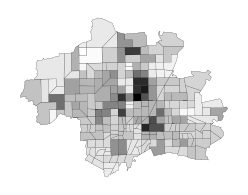

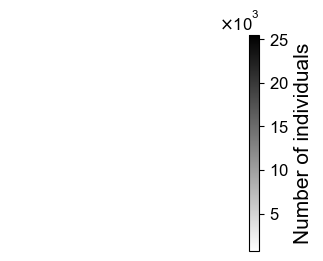

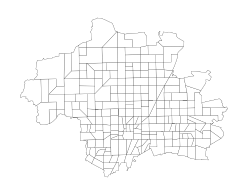

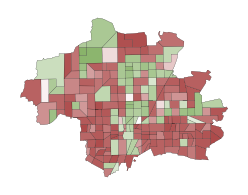

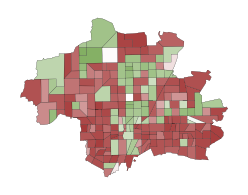

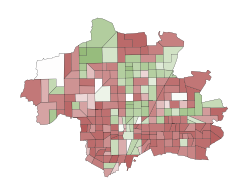

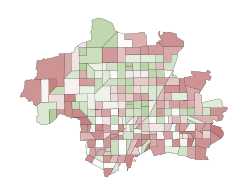

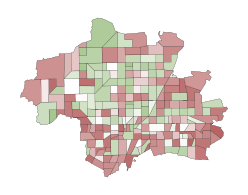

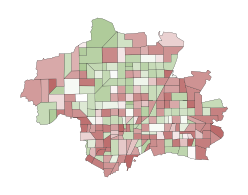

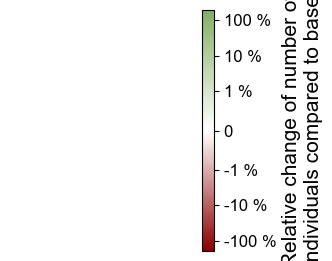

In [ ]:
time_points = [get_time_point(0, 0), get_time_point(0, 8), get_time_point(0, 12), get_time_point(0, 17), get_time_point(0, 20), get_time_point(5, 14), get_time_point(6, 14)]
timepoint_names = ['Mo 12am', 'Mo 8am', 'Mo 12pm', 'Mo 17pm', 'Mo 20pm', 'Sa 14pm', 'So 14pm']
mobility_result = '0_num_agents_area.txt'
ww_areas_shp_file = 'Verschnitt_DLR_TAN_Rep.shp'

ww_dist = get_spatial_density_data(ww_areas_shp_file, mobility_result, time_points)

# Define cmaps
base_cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["white", colors['Black']])
cmap_positive = mcolors.LinearSegmentedColormap.from_list("custom", ["white", colors['Green']])
cmap_negative = mcolors.LinearSegmentedColormap.from_list("custom", ["white", colors['Dark red']])
colors_negative = cmap_negative(np.linspace(1, 0, 128))
colors_positive = cmap_positive(np.linspace(0, 1, 128))
change_cmap = mcolors.ListedColormap(np.vstack([colors_negative, colors_positive]))

# Plot base value
figsize = (3.5, 2.2)
fig, ax = plt.subplots(figsize = figsize)
ww_dist.plot(ax=ax, edgecolor='black', color='white', linewidth = 0.1, legend=False)
norm = mcolors.Normalize(vmin=ww_dist['base'].min(), vmax=ww_dist['base'].max())
ww_dist[ww_dist['base']>0].plot(column='base', ax=ax, cmap = base_cmap, norm=norm, edgecolor='black', linewidth = 0.1, legend=False)
ax.set_axis_off()
plt.tight_layout()
fig.savefig(f'pop_movement_base.png', dpi=dpi)
plt.show()
# Add colorbar
sm = matplotlib.cm.ScalarMappable(cmap=base_cmap, norm=norm)
sm._A = []
# Save cbar in extra figure
fig, ax = plt.subplots(figsize = (figsize[0]/1., figsize[1]*1.3))
cbar = fig.colorbar(sm, ax=ax) #aspect=15, pad=0.5
cbar.set_label('Number of individuals')
ax.set_axis_off()
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((3, 3))
cbar.ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()
fig.savefig(f'pop_movement_base_cbar.png', dpi=dpi)
plt.show()

# Get min and max value for colorbar
all_values = ww_dist[[str(t) for t in time_points]].values.flatten()
vmax = max(abs(all_values.min()), all_values.max())
norm = mcolors.SymLogNorm(linthresh=1, linscale=1, vmin=-vmax, vmax=vmax, base=10)
# Plot one map per time point
for index, t in enumerate(time_points):
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ww_dist.plot(ax=ax, edgecolor='black', color='white', linewidth = 0.1, legend=False)
    ww_dist.plot(column=str(t), ax=ax, cmap = change_cmap, norm = norm, edgecolor='black', linewidth = 0.1, legend=False)
    ax.set_axis_off()    
    plt.tight_layout()
    fig.savefig(f'pop_movement_change_{timepoint_names[index]}.png', dpi=dpi)
    plt.show()
    
# Plot joint colorbar for changes
fig, ax = plt.subplots(figsize = (figsize[0]/1, figsize[1]*1.3))
sm = matplotlib.cm.ScalarMappable(cmap=change_cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
powers = [0, 1, 2]
ticks_plus = [10**p for p in powers]
ticks_minus = [-10**p for p in reversed(powers)]
ticks = ticks_minus + [0] + ticks_plus
tick_labels_plus = [f"{tick} %" for tick in ticks_plus]
tick_labels_minus = [f"{tick} %" for tick in ticks_minus]
tick_labels = tick_labels_minus + ['0'] + tick_labels_plus
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label('Relative change of number of\nindividuals compared to base')
ax.set_axis_off()
plt.tight_layout()
plt.show()
# Save figure
fig.savefig(f'pop_movement_change_cbar.png', dpi=dpi)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


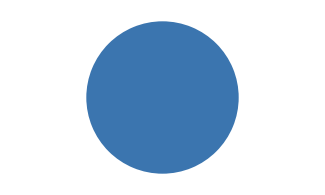

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


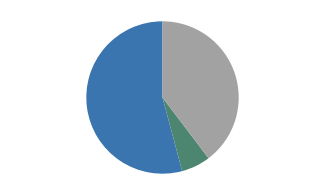

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


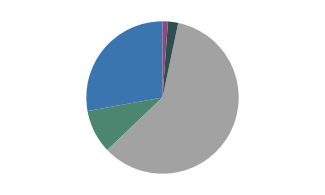

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


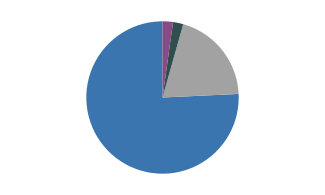

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


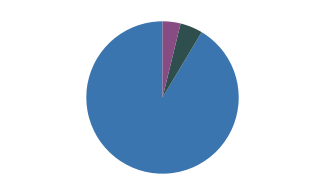

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


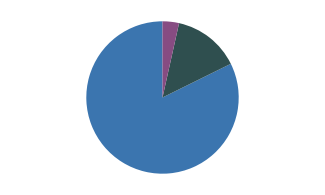

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


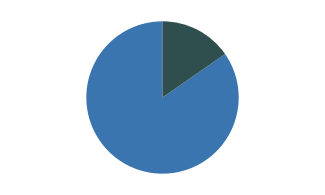

<Figure size 350x220 with 0 Axes>

In [ ]:

loctype_result = '0_num_agents_loc_type.txt'

# Read simulation output
output_loctype = pd.read_csv(loctype_result, sep=',')
output_loctype = output_loctype.drop(['NumAgents'], axis=1)
output_loctype = output_loctype.rename(columns={"t": "LocType", "locType": "NumAgents"})  
# Set line width of plot outline
matplotlib.rcParams['axes.linewidth'] = 0.1                
# Subdf containing only the relevant time points
tp_df = output_loctype[output_loctype.index.isin(time_points)]

# Pie plots with loctype dist
for idx, tp in enumerate(time_points):
    values = tp_df[tp_df.index == tp].NumAgents
    loc_types = tp_df[tp_df.index == tp].LocType
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.pie(values, colors=[loctype_to_color_dict[idx_to_loctype_dict[l]] for l in loc_types], startangle=90)
    plt.tight_layout()
    plt.show()
    fig.savefig(f'num_agents_per_loctype_pie_{timepoint_names[idx]}.png', dpi=dpi) 

# Add legend
patchList = []
for l in tp_df.LocType.unique():
    data_key = patches.Patch(color=loctype_to_color_dict[idx_to_loctype_dict[l]], label=idx_to_loctype_dict[l])
    patchList.append(data_key)

fig = plt.figure(figsize=(figsize[0], figsize[1]))
legend = fig.legend(handles=patchList, loc='center left', bbox_to_anchor=(0, 0.5), ncol = 1)
legend.get_frame().set_linewidth(0.1)
plt.show()
fig.savefig(f'legend_loctypes.png', dpi=dpi)